In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx - border)
        b = np.random.randint(border, ny - border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]

def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

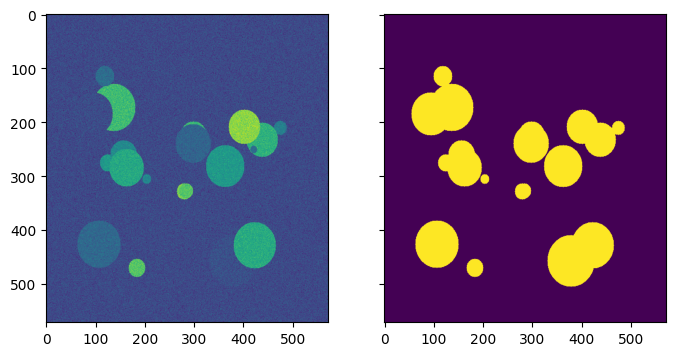

In [2]:
import matplotlib.pyplot as plt

nx = 572
ny = 572
generator = GrayScaleDataProvider(nx, ny, cnt=20)
x_test, y_test = generator(1)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].imshow(x_test[0, ..., 0], aspect="auto")
ax[1].imshow(y_test[0, ..., 1], aspect="auto")

plt.show()

In [3]:
x_test.shape, y_test.shape

((1, 572, 572, 1), (1, 572, 572, 2))

In [6]:
import os

train_images_dir = 'data/train_png/imgs'
train_masks_dir = 'data/train_png/masks'
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)

nx = 572
ny = 572
generator = GrayScaleDataProvider(nx, ny, cnt=20)
for i in range(1500):
    x_train_path = os.path.join(train_images_dir, f'{i}.png')
    y_train_path = os.path.join(train_masks_dir, f'{i}.png')
    
    x_train, y_train = generator(1)
    
    # Сохраняем x_test
    plt.imsave(x_train_path, x_train[0, ..., 0])

    # Сохраняем y_test
    plt.imsave(y_train_path, y_train[0, ..., 1])

In [7]:
test_images_dir = 'data/test_png/imgs'
test_masks_dir = 'data/test_png/masks'
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

nx = 572
ny = 572
generator = GrayScaleDataProvider(nx, ny, cnt=20)
for i in range(150):
    x_test_path = os.path.join(test_images_dir, f'{i}.png')
    y_test_path = os.path.join(test_masks_dir, f'{i}.png')
    
    x_test, y_test = generator(1)
    
    # Сохраняем x_test
    plt.imsave(x_test_path, x_test[0, ..., 0])

    # Сохраняем y_test
    plt.imsave(y_test_path, y_test[0, ..., 1])